# LSTM RNN Model for Citation Level Projection

In [254]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda
from tensorflow.keras.layers import Dropout, Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.initializers import glorot_uniform
from keras.preprocessing import image
from keras.utils import layer_utils, to_categorical
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
#Conv2D output: 4+D tensor with shape: batch_shape + (new_rows, new_cols, filters) 
#if data_format='channels_last'. 
from gensim.models import KeyedVectors
import tensorflow as tf
from gensim import utils
from itertools import compress 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import csv
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pip install gensim

     |████████████████████████████████| 24.2 MB 122 kB/s  eta 0:00:01
     |████████████████████████████████| 119 kB 60.1 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-4.2.0-py3-none-any.whl size=109630 sha256=6e6a4fd7dae917bbf1de9058881fcc288071666d449df808a6e2c0bc77cc1bed
  Stored in directory: /root/.cache/pip/wheels/25/88/e3/7cd51a6379cac37213cac47545a27688782752ff66351b953d
Successfully built smart-open
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Dataset description

* Traning examples will be 200 dimensional word vectors stacked vertically, representing the concatenation of title of abstract section of patents granted since 1970.

* Tech_classes data will be 3 digits CPC classfication of patents

* Citations_class will be a classification based on distribution of 5-year raw citation counts, within the given patent's CPC 3 digit technology class. Each patent has exactly one of the 4 following labels:
 1. Citation count greater or euqal to the 99% percentile (top1%)
 2. Citation count greater or equal to the 90% percentile ()
 3. Citation count less than 90% percentile but at least 1 ()
 4. Citation count is exactly 0 ()

## Patent RNN Model Architecture

In [4]:
#Import the dataframe
dataframe = pd.read_csv("/floyd/input/patent_prerank_upd/patent_rank_upd.csv")

In [9]:
dataframe

,patent_id,abstract,title,five_year_fcite,subsection_id,date,label
0,3930271,A golf glove is disclosed having an extra fing...,Golf glove,0,A63,1976-01-06,4
1,3930272,A lock for a height-adjustable crib or playpen...,Crib leg lock,0,A47,1976-01-06,4
2,3930273,A bed safety side rail arrangement which inclu...,Bed safety side rail arrangement,4,A61,1976-01-06,3
3,3930274,The assembly includes a longitudinal axis and ...,Assembly for use in recreational activities,0,B63,1976-01-06,4
4,3930275,A novel slipper and its method of fabrication ...,Method of fabricating a slipper,0,A43,1976-01-06,4
...,...,...,...,...,...,...,...
5159183,9119332,"An assembly including a substrate, a metal wir...",Method of mounting devices in substrate and de...,0,H05,2015-08-25,4
5159184,9119333,A multilayer wiring board including a build-up...,Multilayer wiring board,0,H05,2015-08-25,4
5159185,9119334,"A circuit board includes layers, a pair of via...",Method for manufacturing circuit board having ...,0,H05,2015-08-25,4
5159186,9119335,A method for manufacturing a rigid-flexible mu...,Method for manufacturing rigid-flexible multil...,0,H05,2015-08-25,4


In [29]:
def Patent_RNN_Model(input_shape = [200, 200], class_num = 4):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    embeddings = Input(shape=input_shape) 
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units = 128, return_sequences= True)(embeddings)#Set the units and return_sequences parameters.
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units = 128, return_sequences= False)(X)
    
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.5)(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense(units = class_num)(X)
    # Add a softmax activation
    X = Activation("softmax")(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = embeddings, outputs = X)
    
    ### END CODE HERE ###
    
    return model

## Training

In [25]:
word_vectors_sg = KeyedVectors.load('word2vec_sg.wordvectors')

def matrix_generator(dataframe, list_IDs_temp, min_len = 50, max_len = 200, dim = (200, 200)):
     '''
    Input:
    filename: name of the csv file we want to read data from
    list_TDs_temp: indeces for minibatch
    min_len: minimum number of tokenized words for a title + abstraction text
    max_len: maximum number of tokenized words for a title + abstraction text
    dim: dimension of outputing matrix representation of text
    
    Output:
    X: batch of matrix representations of num_doc number of title+abstraction texts
    y: labels
    '''
    batch_size = len(list_IDs_temp)
    X = np.zeros((batch_size, *dim))
    y = np.zeros((1, batch_size), dtype = int)
    counter = 0
    
    for idx in list_IDs_temp:
        if dataframe.iloc[idx]["abstract"] == 'NULL':
            line = re.sub('[^a-zA-Z0-9]', ' ', str(dataframe.iloc[idx]["title"])) # remove non-letters and non-numbers
            bool_list = [word in word_vectors_sg for word in utils.simple_preprocess(line)]
            filtered_line = list(compress(utils.simple_preprocess(line), bool_list)) #some infrequency words are not included in the vocab, 
            #we remove then
            length = len(filtered_line)
            if length >= min_len:
                matrix = word_vectors_sg[filtered_line] # generate document matrix representation from tokens
                X_row = np.pad(matrix, ((0, max_len - length),(0, 0))).reshape([*dim])
                X[counter] = X_row
                y[0, counter] = dataframe.iloc[idx]["label"] - 1
        else:
            line = re.sub('[^a-zA-Z0-9]', ' ', str(dataframe.iloc[idx]["title"]) + ' ' + str(dataframe.iloc[idx]["abstract"])) # remove non-letters and non-numbers
            bool_list = [word in word_vectors_sg for word in utils.simple_preprocess(line)]
            filtered_line = list(compress(utils.simple_preprocess(line), bool_list)) #some infrequent words are not included in the vocab, 
            #we remove then
            length = len(filtered_line)
            if length >= min_len and length <= max_len:
                matrix = word_vectors_sg[filtered_line] # generate document matrix representation from tokens
                X_row = np.pad(matrix, ((0, max_len - length),(0, 0))).reshape([*dim])
                X[counter] = X_row
                y[0, counter] = dataframe.iloc[idx]["label"] - 1
            elif length > max_len:
                matrix = word_vectors_sg[filtered_line[0:max_len]] # generate document matrix representation from tokens
                X_row = matrix.reshape([*dim])
                X[counter] = X_row
                y[0, counter] = dataframe.iloc[idx]["label"] - 1
        counter += 1
    return X, np.squeeze(y)

In [128]:
class DataGenerator(Sequence): #This generator is for generating the minibatches for training purpose
    'Generates data for Keras'
    def __init__(self, dataframe, batch_size=100, text_length = 200,
                 n_classes=4, shuffle=False):
        'Initialization'
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.list_IDs = list(range(len(dataframe.loc[:, "patent_id"])))
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.n = 0
        self.max = self.__len__()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataframe.loc[:, "patent_id"]) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X, y = matrix_generator(self.dataframe, list_IDs_temp)
        return X, to_categorical(y, num_classes=self.n_classes)
    
    #def __next__(self):
        #if self.n >= self.max:
           #self.n = 0
        #y = self.__getitem__(self.n)
        #self.n += 1
        #return y

In [149]:
class DataGenerator2(Sequence): #This generator is for generating the ground true label
    'Generates data for Keras'
    def __init__(self, dataframe, batch_size=100, text_length = 200,
                 n_classes=4, shuffle=False):
        'Initialization'
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.list_IDs = list(range(len(dataframe.loc[:, "patent_id"])))
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.n = 0
        self.max = self.__len__()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataframe.loc[:, "patent_id"]) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        y = self.__data_generation(list_IDs_temp)

        return y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        _, y = matrix_generator(self.dataframe, list_IDs_temp)
        return to_categorical(y, num_classes=self.n_classes)
    
    def __next__(self):
        if self.n >= self.max:
           self.n = 0
        y = self.__getitem__(self.n)
        self.n += 1
        return y

In [6]:
train = dataframe.loc[dataframe["date"] < '2011-01-01'] 
test = pd.concat([dataframe,train]).drop_duplicates(keep=False)

# Generators
training_generator = DataGenerator(train)
validation_generator = DataGenerator(test)

In [30]:
patentmodel = Patent_RNN_Model()
patentmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200)]        0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 128)          168448    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 516       
_________________________________________________________________
activation (Activation)      (None, 4)                 0     

In [31]:
patentmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
patentmodel.fit(training_generator, validation_data = validation_generator, epochs = 5)

Epoch 1/5
39107/39107 [==============================] - 11268s 288ms/step - loss: 0.8634 - accuracy: 0.6306 - val_loss: 0.9560 - val_accuracy: 0.5414
Epoch 2/5
39107/39107 [==============================] - 11268s 288ms/step - loss: 0.8420 - accuracy: 0.6338 - val_loss: 0.9500 - val_accuracy: 0.5376
Epoch 3/5
39107/39107 [==============================] - 11332s 290ms/step - loss: 0.8343 - accuracy: 0.6350 - val_loss: 0.9461 - val_accuracy: 0.5412
Epoch 4/5
39107/39107 [==============================] - 11284s 289ms/step - loss: 0.8291 - accuracy: 0.6357 - val_loss: 0.9496 - val_accuracy: 0.5394
Epoch 5/5
39107/39107 [==============================] - 11318s 289ms/step - loss: 0.8277 - accuracy: 0.6354 - val_loss: 0.9366 - val_accuracy: 0.5480


In [16]:
patentmodel.save('RNN_citation_v2')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: RNN_citation_v2/assets


In [32]:
patentmodel = load_model('RNN_citation_v2')

# Test and calculation of performance metrics

In [10]:
test_2011 = test.loc[(dataframe["date"] >= '2011-01-01') & (dataframe["date"] < '2012-01-01')] 

In [11]:
test_2012 = test.loc[(dataframe["date"] >= '2012-01-01') & (dataframe["date"] < '2013-01-01')] 

In [18]:
test_2013 = test.loc[(dataframe["date"] >= '2013-01-01') & (dataframe["date"] < '2014-01-01')] 

In [19]:
test_2014 = test.loc[(dataframe["date"] >= '2014-01-01') & (dataframe["date"] < '2015-01-01')] 

In [20]:
test_2015 = test.loc[dataframe["date"] >= '2015-01-01'] 

In [180]:
print(test.shape)
print(test_2011.shape)
print(test_2012.shape)
print(test_2013.shape)
print(test_2014.shape)
print(test_2015.shape)
print(test_2011.shape[0] + test_2012.shape[0] + test_2013.shape[0] + test_2014.shape[0] + test_2015.shape[0])

(1248439, 7)
(224496, 7)
(253145, 7)
(277813, 7)
(300655, 7)
(192330, 7)
1248439


In [129]:
validation_generator_2011 = DataGenerator(test_2011)
validation_generator_2012 = DataGenerator(test_2012)
validation_generator_2013 = DataGenerator(test_2013)
validation_generator_2014 = DataGenerator(test_2014)
validation_generator_2015 = DataGenerator(test_2015)

In [130]:
patentmodel.evaluate(validation_generator_2011)

2244/2244 [==============================] - 470s 209ms/step - loss: 0.8957 - accuracy: 0.5855


[0.8957116603851318, 0.5855302810668945]

In [132]:
patentmodel.evaluate(validation_generator_2012)

2531/2531 [==============================] - 531s 210ms/step - loss: 0.9152 - accuracy: 0.5689


[0.9151543378829956, 0.5689292550086975]

In [133]:
patentmodel.evaluate(validation_generator_2013)

2778/2778 [==============================] - 582s 209ms/step - loss: 0.9404 - accuracy: 0.5463


[0.9403634071350098, 0.546310305595398]

In [134]:
patentmodel.evaluate(validation_generator_2014)

3006/3006 [==============================] - 629s 209ms/step - loss: 0.9599 - accuracy: 0.5266


[0.9599047899246216, 0.5265569090843201]

In [135]:
patentmodel.evaluate(validation_generator_2015)

1923/1923 [==============================] - 404s 210ms/step - loss: 0.9702 - accuracy: 0.5126


[0.9702480435371399, 0.5126364827156067]

In [137]:
prediction_2011 = patentmodel.predict(validation_generator_2011)

In [119]:
prediction_2011.shape

(224400, 4)

In [141]:
prediction_2012 = patentmodel.predict(validation_generator_2012)

In [142]:
prediction_2013 = patentmodel.predict(validation_generator_2013)

In [143]:
prediction_2014 = patentmodel.predict(validation_generator_2014)

In [144]:
prediction_2015 = patentmodel.predict(validation_generator_2015)

In [138]:
classes_prediction_2011 = np.argmax(prediction_2011, axis = 1)

In [145]:
classes_prediction_2012 = np.argmax(prediction_2012, axis = 1)

In [146]:
classes_prediction_2013 = np.argmax(prediction_2013, axis = 1)

In [147]:
classes_prediction_2014 = np.argmax(prediction_2014, axis = 1)

In [148]:
classes_prediction_2015 = np.argmax(prediction_2015, axis = 1)

In [150]:
validation_generator2_2011 = DataGenerator2(test_2011)
validation_generator2_2012 = DataGenerator2(test_2012)
validation_generator2_2013 = DataGenerator2(test_2013)
validation_generator2_2014 = DataGenerator2(test_2014)
validation_generator2_2015 = DataGenerator2(test_2015)

In [123]:
labels = []
for i in range(224496 // 100):
    y = next(validation_generator2_2011)
    labels.append(y) 

In [159]:
ground_true_2011 = np.vstack(labels)

In [160]:
ground_true_2011_int = np.argmax(ground_true_2011, axis=1)

In [166]:
len(ground_true_2011_int)

224400

In [217]:
bool_list_top1_2011 = []
num_top1_2011 = 0
for i in range(224400):
    if ground_true_2011_int[i] == 0:
        num_top1_2011 += 1
        if ground_true_2011_int[i] == classes_prediction_2011[i]:
            bool_list_top1_2011.append(True)
        else:
            bool_list_top1_2011.append(False)
        

In [218]:
sum(bool_list_top1_2011) / num_top1_2011

0.8375007285656001

In [151]:
labels2 = []
for i in range(253145 // 100):
    y = next(validation_generator2_2012)
    labels2.append(y) 

In [152]:
ground_true_2012 = np.vstack(labels2)

In [153]:
ground_true_2012_int = np.argmax(ground_true_2012, axis=1)

In [163]:
len(ground_true_2012_int)

253100

In [219]:
bool_list_top1_2012 = []
num_top1_2012 = 0
for i in range(253100):
    if ground_true_2012_int[i] == 0:
        num_top1_2012 += 1
        if ground_true_2012_int[i] == classes_prediction_2012[i]:
            bool_list_top1_2012.append(True)
        else:
            bool_list_top1_2012.append(False)

In [220]:
sum(bool_list_top1_2012) / num_top1_2012

0.8231519507186859

In [167]:
labels3 = []
for i in range(277813 // 100):
    y = next(validation_generator2_2013)
    labels3.append(y) 

In [168]:
ground_true_2013 = np.vstack(labels3)

In [169]:
ground_true_2013_int = np.argmax(ground_true_2013, axis=1)

In [170]:
len(ground_true_2013_int)

277800

In [221]:
bool_list_top1_2013 = []
num_top1_2013 = 0
for i in range(277800):
    if ground_true_2013_int[i] == 0:
        num_top1_2013 += 1
        if ground_true_2013_int[i] == classes_prediction_2013[i]:
            bool_list_top1_2013.append(True)
        else:
            bool_list_top1_2013.append(False)

In [222]:
sum(bool_list_top1_2013) / num_top1_2013

0.8270931326434618

In [176]:
labels4 = []
for i in range(300655 // 100):
    y = next(validation_generator2_2014)
    labels4.append(y) 

In [177]:
ground_true_2014 = np.vstack(labels4)

In [178]:
ground_true_2014_int = np.argmax(ground_true_2014, axis=1)

In [179]:
len(ground_true_2014_int)

300600

In [227]:
bool_list_top1_2014 = []
num_top1_2014 = 0
for i in range(300600):
    if ground_true_2014_int[i] == 0:
        num_top1_2014 += 1
        if ground_true_2014_int[i] == classes_prediction_2014[i]:
            bool_list_top1_2014.append(True)
        else:
            bool_list_top1_2014.append(False)

In [228]:
sum(bool_list_top1_2014) / num_top1_2014 

0.8289172535211268

In [183]:
labels5 = []
for i in range(192330 // 100):
    y = next(validation_generator2_2015)
    labels5.append(y) 

In [184]:
ground_true_2015 = np.vstack(labels5)

In [185]:
ground_true_2015_int = np.argmax(ground_true_2015, axis=1)

In [211]:
len(ground_true_2015_int)

192300

In [225]:
bool_list_top1_2015 = []
num_top1_2015 = 0
for i in range(192300):
    if ground_true_2015_int[i] == 0:
        num_top1_2015 += 1
        if ground_true_2015_int[i] == classes_prediction_2015[i]:
            bool_list_top1_2015.append(True)
        else:
            bool_list_top1_2015.append(False)

In [226]:
sum(bool_list_top1_2015) / num_top1_2015

0.8326265196494204

In [264]:
cnf_matrix_2011_row = confusion_matrix(ground_true_2011_int, classes_prediction_2011, normalize = 'true')
cnf_matrix_2011_col = confusion_matrix(ground_true_2011_int, classes_prediction_2011, normalize = 'pred')

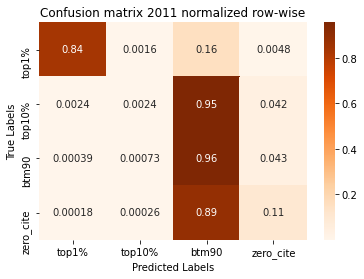

In [288]:
columns = ['top1%','top10%', 'btm90', 'zero_cite']
df_cm = pd.DataFrame(cnf_matrix_2011_row, index=columns, columns=columns)

ax = sns.heatmap(df_cm, cmap='Oranges', annot=True)
plt.title('Confusion matrix 2011 normalized row-wise')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig('conf_matrix_2011_row.png')

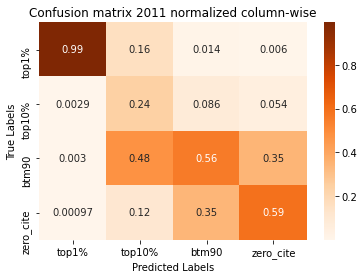

In [289]:
columns = ['top1%','top10%', 'btm90', 'zero_cite']
df_cm = pd.DataFrame(cnf_matrix_2011_col, index=columns, columns=columns)

ax = sns.heatmap(df_cm, cmap='Oranges', annot=True)
plt.title('Confusion matrix 2011 normalized column-wise')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig('conf_matrix_2011_col.png')

In [192]:
print(classification_report(ground_true_2011_int, classes_prediction_2011))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     17157
           1       0.24      0.00      0.00     17651
           2       0.56      0.96      0.70    113744
           3       0.59      0.11      0.18     75848

    accuracy                           0.59    224400
   macro avg       0.60      0.48      0.45    224400
weighted avg       0.58      0.59      0.49    224400



In [271]:
cnf_matrix_2012_row = confusion_matrix(ground_true_2012_int, classes_prediction_2012, normalize = 'true')
cnf_matrix_2012_col = confusion_matrix(ground_true_2012_int, classes_prediction_2012, normalize = 'pred')

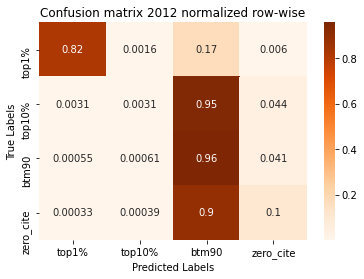

In [290]:
columns = ['top1%','top10%', 'btm90', 'zero_cite']
df_cm = pd.DataFrame(cnf_matrix_2012_row, index=columns, columns=columns)

ax = sns.heatmap(df_cm, cmap='Oranges', annot=True)
plt.title('Confusion matrix 2012 normalized row-wise')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig('conf_matrix_2012_row.png')

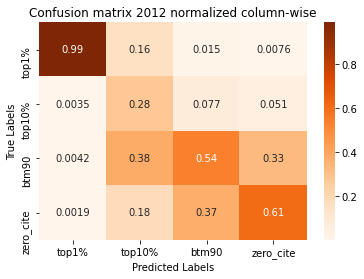

In [291]:
columns = ['top1%','top10%', 'btm90', 'zero_cite']
df_cm = pd.DataFrame(cnf_matrix_2012_col, index=columns, columns=columns)

ax = sns.heatmap(df_cm, cmap='Oranges', annot=True)
plt.title('Confusion matrix 2012 normalized column-wise')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig('conf_matrix_2012_col.png')

In [194]:
print(classification_report(ground_true_2012_int, classes_prediction_2012))

              precision    recall  f1-score   support

           0       0.99      0.82      0.90     19480
           1       0.28      0.00      0.01     17913
           2       0.54      0.96      0.69    123669
           3       0.61      0.10      0.18     92038

    accuracy                           0.57    253100
   macro avg       0.60      0.47      0.44    253100
weighted avg       0.58      0.57      0.47    253100



In [275]:
cnf_matrix_2013_row = confusion_matrix(ground_true_2013_int, classes_prediction_2013, normalize = 'true')
cnf_matrix_2013_col = confusion_matrix(ground_true_2013_int, classes_prediction_2013, normalize = 'pred')

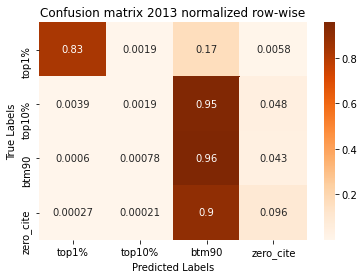

In [292]:
columns = ['top1%','top10%', 'btm90', 'zero_cite']
df_cm = pd.DataFrame(cnf_matrix_2013_row, index=columns, columns=columns)

ax = sns.heatmap(df_cm, cmap='Oranges', annot=True)
plt.title('Confusion matrix 2013 normalized row-wise')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig('conf_matrix_2013_row.png')

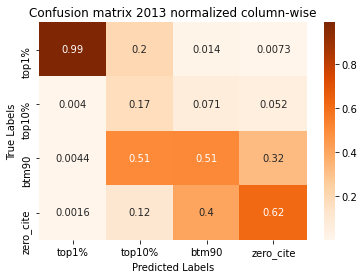

In [293]:
columns = ['top1%','top10%', 'btm90', 'zero_cite']
df_cm = pd.DataFrame(cnf_matrix_2013_col, index=columns, columns=columns)

ax = sns.heatmap(df_cm, cmap='Oranges', annot=True)
plt.title('Confusion matrix 2013 normalized column-wise')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig('conf_matrix_2013_column.png')

In [196]:
print(classification_report(ground_true_2013_int, classes_prediction_2013))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90     21260
           1       0.17      0.00      0.00     18340
           2       0.51      0.96      0.66    129388
           3       0.62      0.10      0.17    108812

    accuracy                           0.55    277800
   macro avg       0.57      0.47      0.43    277800
weighted avg       0.57      0.55      0.44    277800



In [280]:
cnf_matrix_2014_row = confusion_matrix(ground_true_2014_int, classes_prediction_2014, normalize = 'true')
cnf_matrix_2014_col = confusion_matrix(ground_true_2014_int, classes_prediction_2014, normalize = 'pred')

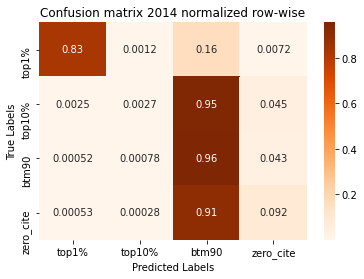

In [294]:
columns = ['top1%','top10%', 'btm90', 'zero_cite']
df_cm = pd.DataFrame(cnf_matrix_2014_row, index=columns, columns=columns)

ax = sns.heatmap(df_cm, cmap='Oranges', annot=True)
plt.title('Confusion matrix 2014 normalized row-wise')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig('conf_matrix_2014_row.png')

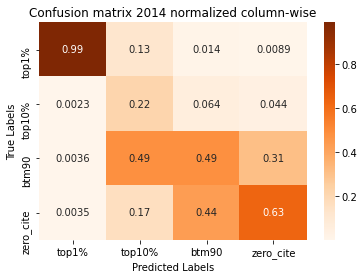

In [295]:
columns = ['top1%','top10%', 'btm90', 'zero_cite']
df_cm = pd.DataFrame(cnf_matrix_2014_col, index=columns, columns=columns)

ax = sns.heatmap(df_cm, cmap='Oranges', annot=True)
plt.title('Confusion matrix 2014 normalized column-wise')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig('conf_matrix_2014_column.png')

In [198]:
print(classification_report(ground_true_2014_int, classes_prediction_2014))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90     22720
           1       0.22      0.00      0.01     17658
           2       0.49      0.96      0.64    133686
           3       0.63      0.09      0.16    126536

    accuracy                           0.53    300600
   macro avg       0.58      0.47      0.43    300600
weighted avg       0.57      0.53      0.42    300600



In [284]:
cnf_matrix_2015_row = confusion_matrix(ground_true_2015_int, classes_prediction_2015, normalize = 'true')
cnf_matrix_2015_col = confusion_matrix(ground_true_2015_int, classes_prediction_2015, normalize = 'pred')

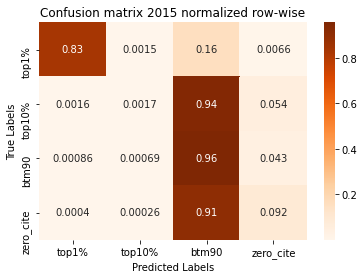

In [296]:
columns = ['top1%','top10%', 'btm90', 'zero_cite']
df_cm = pd.DataFrame(cnf_matrix_2015_row, index=columns, columns=columns)

ax = sns.heatmap(df_cm, cmap='Oranges', annot=True)
plt.title('Confusion matrix 2015 normalized row-wise')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig('conf_matrix_2015_row.png')

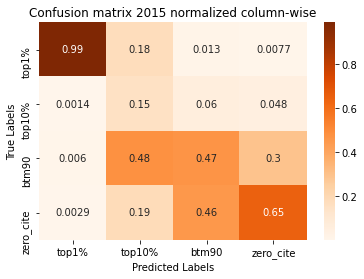

In [297]:
columns = ['top1%','top10%', 'btm90', 'zero_cite']
df_cm = pd.DataFrame(cnf_matrix_2015_col, index=columns, columns=columns)

ax = sns.heatmap(df_cm, cmap='Oranges', annot=True)
plt.title('Confusion matrix 2015 normalized column-wise')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig('conf_matrix_2015_column.png')

In [190]:
print(classification_report(ground_true_2015_int, classes_prediction_2015))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90     14148
           1       0.15      0.00      0.00     10751
           2       0.47      0.96      0.63     82674
           3       0.65      0.09      0.16     84727

    accuracy                           0.51    192300
   macro avg       0.56      0.47      0.42    192300
weighted avg       0.57      0.51      0.41    192300

